# Height Prediction Model Training - Run 5

**Objective:** Fix Run 4 overfitting issues with simplified residual architecture

## Run 5 Strategy (Based on Professor's Top Submissions)

1. **REMOVE** multi-head attention (too complex, not worth it)
2. **REMOVE** aggressive group weighting (caused 60-70% degradation in easy cases)
3. **ADD** residual connections with LayerNorm (proven in top submissions)
4. **ADD** progressive width reduction (1024→512→256→128)
5. **ADD** progressive dropout pattern (0.3→0.2→0.1)
6. **USE** mild class weighting (1.0-2.0x max, not 5.0x)
7. **IMPROVE** learning rate schedule with exponential decay
8. **EXTEND** training with better early stopping (patience=40, max_epochs=250)
9. **ADD** data augmentation targeting hard/medium cases

## Expected Performance

- Easy cases: < 0.15 log2-MSE (match Run 2, don't degrade!)
- Medium cases: 0.20-0.30 log2-MSE
- Hard cases: 0.80-1.30 log2-MSE (match Run 4)
- Overall: 0.30-0.35 (beat 0.374 target!)

## Setup and Imports

In [41]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Embedding, Flatten, Concatenate,
    Dropout, BatchNormalization, Add, LayerNormalization, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,
    Callback, LearningRateScheduler
)
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*70)
print("HEIGHT PREDICTION MODEL - RUN 5 (SIMPLIFIED RESIDUAL)")
print("="*70)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

HEIGHT PREDICTION MODEL - RUN 5 (SIMPLIFIED RESIDUAL)
TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 1: Load Data

In [42]:
print("STEP 1: Loading Data")
print("-"*70)

with open('combined_final_n_k_m_P.pkl', 'rb') as f:
    inputs_raw = pickle.load(f)

with open('combined_final_mHeights.pkl', 'rb') as f:
    outputs_raw = pickle.load(f)

print(f"Raw input samples: {len(inputs_raw)}")
print(f"Raw output samples: {len(outputs_raw)}")
if len(inputs_raw) > 0:
    sample = inputs_raw[0]
    print(f"Sample structure: [n={sample[0]}, k={sample[1]}, m={sample[2]}, P_matrix shape={sample[3].shape}]")
print(f"Output range: [{np.min(outputs_raw):.2f}, {np.max(outputs_raw):.2f}]")

STEP 1: Loading Data
----------------------------------------------------------------------
Raw input samples: 108000
Raw output samples: 108000
Sample structure: [n=9, k=5, m=3, P_matrix shape=(5, 4)]
Output range: [2.00, 33517570.00]


## Step 2: Data Augmentation

Apply targeted augmentation:
- Hard cases (k=5,m=4 | k=6,m=3 | k=4,m=5): +2 augmented copies each
- Medium cases (k=4,m=4 | k=5,m=3 | k=6,m=2): +1 augmented copy each
- Easy cases: No augmentation

In [43]:
def augment_sample(n, k, m, P_matrix, m_height, noise_scale=0.02):
    """
    Augment a single sample by adding small noise
    """
    # Add small noise to n (±2%)
    n_aug = n * (1 + np.random.uniform(-noise_scale, noise_scale))
    n_aug = max(1.0, n_aug)  # Ensure n >= 1

    # Add small noise to P matrix and renormalize
    P_aug = P_matrix.copy()
    if P_aug.size > 0:
        noise = np.random.normal(0, noise_scale, P_aug.shape)
        P_aug = P_aug + noise
        P_aug = np.clip(P_aug, 0, 1)  # Keep in [0, 1]

        # Renormalize rows to sum to 1
        if len(P_aug.shape) == 2:
            row_sums = P_aug.sum(axis=1, keepdims=True)
            row_sums = np.maximum(row_sums, 1e-7)
            P_aug = P_aug / row_sums

    return (n_aug, k, m, P_aug), m_height

# Define augmentation multipliers
HARD_GROUPS = [(5, 4), (6, 3), (4, 5)]
MEDIUM_GROUPS = [(4, 4), (5, 3), (6, 2)]

augmentation_config = {
    (5, 4): 50, (6, 3): 50, (4, 5): 50,  # Hard cases: +2 copies
    (4, 4): 25, (5, 3): 25, (6, 2): 25,  # Medium cases: +1 copy
}

inputs_augmented = []
outputs_augmented = []

print("Augmenting dataset...")
for sample, target in zip(inputs_raw, outputs_raw):
    n, k, m, P_matrix = sample

    # Always keep original
    inputs_augmented.append(sample)
    outputs_augmented.append(target)

    # Add augmented copies
    num_augmented = augmentation_config.get((k, m), 0)
    for _ in range(num_augmented):
        aug_sample, aug_target = augment_sample(n, k, m, P_matrix, target)
        inputs_augmented.append(aug_sample)
        outputs_augmented.append(aug_target)

print(f"Original samples: {len(inputs_raw)}")
print(f"Augmented samples: {len(inputs_augmented)}")
print(f"Augmentation ratio: {len(inputs_augmented) / len(inputs_raw):.2f}x")

Augmenting dataset...
Original samples: 108000
Augmented samples: 2808000
Augmentation ratio: 26.00x


## Step 3: Prepare Data for Training

In [44]:
print("STEP 3: Preparing Data for Training")
print("-"*70)

inputs_rebalanced = inputs_augmented
outputs_rebalanced = outputs_augmented

n_values = []
k_values = []
m_values = []
P_matrices_flattened = []

for sample in inputs_rebalanced:
    n_values.append(sample[0])
    k_values.append(sample[1])
    m_values.append(sample[2])
    P_matrices_flattened.append(sample[3].flatten())

n_values = np.array(n_values, dtype=np.float32).reshape(-1, 1)
k_values = np.array(k_values, dtype=np.int32).reshape(-1, 1)
m_values = np.array(m_values, dtype=np.int32).reshape(-1, 1)
outputs_array = np.array(outputs_rebalanced, dtype=np.float32)

# Pad P matrices
max_p_size = max(len(p) for p in P_matrices_flattened)
P_matrices_padded = []

for p in P_matrices_flattened:
    if len(p) < max_p_size:
        padded = np.zeros(max_p_size, dtype=np.float32)
        padded[:len(p)] = p
        P_matrices_padded.append(padded)
    else:
        P_matrices_padded.append(p)

P_matrices = np.array(P_matrices_padded, dtype=np.float32)

# Normalize P matrices
scaler = StandardScaler()
P_matrices_normalized = scaler.fit_transform(P_matrices)

outputs_array = np.maximum(outputs_array, 1.0)

print(f"n_values shape: {n_values.shape}")
print(f"k_values shape: {k_values.shape}, range: [{k_values.min()}, {k_values.max()}]")
print(f"m_values shape: {m_values.shape}, range: [{m_values.min()}, {m_values.max()}]")
print(f"P_matrices shape: {P_matrices.shape}")
print(f"P matrices normalized: mean={P_matrices_normalized.mean():.4f}, std={P_matrices_normalized.std():.4f}")
print(f"Output (m-height) range: [{outputs_array.min():.2f}, {outputs_array.max():.2f}]")

STEP 3: Preparing Data for Training
----------------------------------------------------------------------
n_values shape: (2808000, 1)
k_values shape: (2808000, 1), range: [4, 6]
m_values shape: (2808000, 1), range: [2, 5]
P_matrices shape: (2808000, 20)
P matrices normalized: mean=0.0000, std=1.0000
Output (m-height) range: [2.00, 33517570.00]


## Step 4: Stratified Train-Val Split

In [45]:
print("STEP 4: Creating Stratified Train-Validation Split")
print("-"*70)

stratify_labels = k_values.flatten() * 10 + m_values.flatten()

(n_train, n_val,
 k_train, k_val,
 m_train, m_val,
 P_train, P_val,
 y_train, y_val,
 strat_train, strat_val) = train_test_split(
    n_values, k_values, m_values, P_matrices_normalized, outputs_array,
    stratify_labels,
    test_size=0.15,
    random_state=42,
    stratify=stratify_labels
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")

STEP 4: Creating Stratified Train-Validation Split
----------------------------------------------------------------------
Training samples: 2386800
Validation samples: 421200


## Step 5: Define Complexity Groups

In [46]:
EASY_GROUPS = [(4, 2), (4, 3), (5, 2)]
MEDIUM_GROUPS = [(4, 4), (5, 3), (6, 2)]
HARD_GROUPS = [(5, 4), (6, 3), (4, 5)]

print(f"Easy groups (Run 2: 0.096-0.108): {EASY_GROUPS}")
print(f"Medium groups (Run 2: 0.210-0.356): {MEDIUM_GROUPS}")
print(f"Hard groups (Run 2: 0.958-1.422): {HARD_GROUPS}")

Easy groups (Run 2: 0.096-0.108): [(4, 2), (4, 3), (5, 2)]
Medium groups (Run 2: 0.210-0.356): [(4, 4), (5, 3), (6, 2)]
Hard groups (Run 2: 0.958-1.422): [(5, 4), (6, 3), (4, 5)]


## Step 6: Build Simplified Residual Model

Key improvements over Run 4:
- NO multi-head attention (removed complexity)
- LayerNorm + BatchNorm combination
- Only 2 residual blocks (reduced from 3-4)
- Progressive width reduction (1024→512→256→128)
- Progressive dropout (0.3→0.2→0.1)
- Softplus output for log2 constraint

In [47]:
def build_simplified_residual_model(p_shape, k_vocab_size=7, m_vocab_size=6):
    # Inputs
    n_input = Input(shape=(1,), name='n')
    k_input = Input(shape=(1,), name='k', dtype=tf.int32)
    m_input = Input(shape=(1,), name='m', dtype=tf.int32)
    P_input = Input(shape=(p_shape,), name='P_flat')

    # Embeddings
    k_embed = Flatten()(Embedding(k_vocab_size, 32, name='k_embedding')(k_input))
    m_embed = Flatten()(Embedding(m_vocab_size, 32, name='m_embedding')(m_input))

    # Initial P processing
    x = Dense(256, activation='gelu', name='P_initial_1')(P_input)
    x = LayerNormalization(name='P_ln1')(x)
    x = Dropout(0.3)(x)

    x = Dense(512, activation='gelu', name='P_initial_2')(x)
    x = LayerNormalization(name='P_ln2')(x)
    x = Dropout(0.2)(x)

    # Combine with embeddings
    x = Concatenate(name='combine_embeddings')([n_input, k_embed, m_embed, x])

    # Initial dense layer
    x = Dense(1024, activation='gelu', name='main_dense1')(x)
    x = LayerNormalization(name='main_ln1')(x)
    x = Dropout(0.3)(x)

    # Residual Block 1
    residual = x
    x = Dense(1024, activation='gelu', name='res1_dense1')(x)
    x = LayerNormalization(name='res1_ln1')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='gelu', name='res1_dense2')(x)
    x = LayerNormalization(name='res1_ln2')(x)
    x = Add(name='res1_add')([x, residual])

    # Residual Block 2
    residual = x
    x = Dense(1024, activation='gelu', name='res2_dense1')(x)
    x = LayerNormalization(name='res2_ln1')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='gelu', name='res2_dense2')(x)
    x = LayerNormalization(name='res2_ln2')(x)
    x = Add(name='res2_add')([x, residual])

    # Progressive width reduction
    x = Dense(512, activation='gelu', name='reduction1')(x)
    x = LayerNormalization(name='reduction_ln1')(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='gelu', name='reduction2')(x)
    x = LayerNormalization(name='reduction_ln2')(x)
    x = Dropout(0.1)(x)

    x = Dense(128, activation='gelu', name='reduction3')(x)
    x = LayerNormalization(name='reduction_ln3')(x)
    x = Dropout(0.1)(x)

    # Output: Predict log2(m-height) then convert to m-height
    log2_pred = Dense(1, activation='linear', name='log2_output')(x)
    log2_pred_positive = Lambda(lambda z: tf.nn.softplus(z), name='softplus')(log2_pred)
    m_height_pred = Lambda(lambda z: tf.pow(2.0, z), name='m_height')(log2_pred_positive)

    model = Model(
        inputs=[n_input, k_input, m_input, P_input],
        outputs=m_height_pred,
        name='simplified_residual_model_v5'
    )

    return model

p_shape = P_train.shape[1]
model = build_simplified_residual_model(
    p_shape,
    k_vocab_size=k_values.max()+1,
    m_vocab_size=m_values.max()+1
)

print(f"Model built successfully!")
print(f"Total parameters: {model.count_params():,}")

Model built successfully!
Total parameters: 5,630,369


## Step 7: Define Loss Function

In [48]:
def log2_mse_loss(y_true, y_pred):
    """MSE in log2 space"""
    epsilon = 1e-7
    y_true = tf.maximum(y_true, epsilon)
    y_pred = tf.maximum(y_pred, epsilon)

    log2_true = tf.math.log(y_true) / tf.math.log(2.0)
    log2_pred = tf.math.log(y_pred) / tf.math.log(2.0)

    return tf.reduce_mean(tf.square(log2_true - log2_pred))

print("Custom log2-MSE loss function defined")

Custom log2-MSE loss function defined


## Step 8: MILD Group Weighting (CRITICAL FIX!)

**CRITICAL:** Run 4 used 5.0x weighting which caused 60-70% degradation in easy cases.  
**Run 5:** Use MILD weighting (1.0-2.0x max) to avoid overfitting to hard cases.

In [49]:
group_weights = {
    (4, 2): 1.0,   # Easy
    (4, 3): 1.0,   # Easy
    (4, 4): 1.0,   # Medium
    (4, 5): 2.0,   # Hard (was 5.0+ in Run 4 - TOO AGGRESSIVE!)
    (5, 2): 1.0,   # Easy
    (5, 3): 1.0,   # Medium
    (5, 4): 1.5,   # Hard (was 3.0+ in Run 4)
    (6, 2): 1.2,   # Medium
    (6, 3): 1.5,   # Hard (was 3.0+ in Run 4)
}

sample_weights_train = np.ones(len(y_train), dtype=np.float32)

for i, (k, m) in enumerate(zip(k_train, m_train)):
    key = (k[0], m[0])
    if key in group_weights:
        sample_weights_train[i] = group_weights[key]

print("Group weights (MILD - not aggressive):")
for (k, m), weight in sorted(group_weights.items()):
    print(f"  k={k}, m={m}: {weight:.1f}x")
print()
print("CRITICAL: Max weight is 2.0x (was 5.0x+ in Run 4)")

Group weights (MILD - not aggressive):
  k=4, m=2: 1.0x
  k=4, m=3: 1.0x
  k=4, m=4: 1.0x
  k=4, m=5: 2.0x
  k=5, m=2: 1.0x
  k=5, m=3: 1.0x
  k=5, m=4: 1.5x
  k=6, m=2: 1.2x
  k=6, m=3: 1.5x

CRITICAL: Max weight is 2.0x (was 5.0x+ in Run 4)


## Step 9: Compile Model

In [50]:
optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
    clipnorm=1.0  # Gradient clipping
)

model.compile(
    optimizer=optimizer,
    loss=log2_mse_loss,
    metrics=[log2_mse_loss]
)

print("Model compiled with AdamW optimizer")
print(f"  Learning rate: 1e-3")
print(f"  Weight decay: 1e-4")
print(f"  Gradient clipping: 1.0")

Model compiled with AdamW optimizer
  Learning rate: 1e-3
  Weight decay: 1e-4
  Gradient clipping: 1.0


## Step 10: Setup Callbacks

In [51]:
def lr_schedule(epoch, lr):
    """Exponential decay schedule"""
    if epoch < 10:
        return lr  # Warmup phase
    else:
        return lr * 0.95  # Decay by 5% each epoch

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=15,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model_run5.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    lr_scheduler
]

print("Callbacks configured:")
print("  - EarlyStopping (patience=40)")
print("  - ReduceLROnPlateau (patience=15, factor=0.7)")
print("  - ModelCheckpoint (best_model_run5.h5)")
print("  - Exponential LR decay (0.95 per epoch)")

Callbacks configured:
  - EarlyStopping (patience=40)
  - ReduceLROnPlateau (patience=15, factor=0.7)
  - ModelCheckpoint (best_model_run5.h5)
  - Exponential LR decay (0.95 per epoch)


## Step 11: Train Model

In [52]:
print("="*70)
print("TRAINING MODEL")
print("="*70)
print(f"Batch size: 256")
print(f"Max epochs: 250")
print(f"Strategy: Simplified architecture + MILD weighting")

history = model.fit(
    [n_train, k_train, m_train, P_train],
    y_train,
    sample_weight=sample_weights_train,
    validation_data=([n_val, k_val, m_val, P_val], y_val),
    epochs=250,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

TRAINING MODEL
Batch size: 256
Max epochs: 250
Strategy: Simplified architecture + MILD weighting

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - log2_mse_loss: 12.3096 - loss: 4.8505
Epoch 1: val_loss improved from inf to 2.51600, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - log2_mse_loss: 12.3096 - loss: 4.8504 - val_log2_mse_loss: 12.0923 - val_loss: 2.5160 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/250
9314/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 12.5045 - loss: 3.8720
Epoch 2: val_loss improved from 2.51600 to 2.49552, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - log2_mse_loss: 12.5044 - loss: 3.8720 - val_log2_mse_loss: 12.2390 - val_loss: 2.4955 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/250
9316/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 12.5094 - loss: 3.8128
Epoch 3: val_loss improved from 2.49552 to 2.38038, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 12.5094 - loss: 3.8128 - val_log2_mse_loss: 12.2411 - val_loss: 2.3804 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/250
9316/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 12.6186 - loss: 3.6034
Epoch 4: val_loss improved from 2.38038 to 1.94231, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 12.6187 - loss: 3.6033 - val_log2_mse_loss: 12.4403 - val_loss: 1.9423 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/250
9323/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 12.8989 - loss: 3.1574
Epoch 5: val_loss improved from 1.94231 to 1.43479, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 12.8989 - loss: 3.1574 - val_log2_mse_loss: 13.2194 - val_loss: 1.4348 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/250
9320/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.1824 - loss: 2.7050
Epoch 6: val_loss improved from 1.43479 to 1.07322, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.1825 - loss: 2.7050 - val_log2_mse_loss: 13.6090 - val_loss: 1.0732 - learning_rate: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.3941 - loss: 2.3719
Epoch 7: val_loss improved from 1.07322 to 0.90625, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.3941 - loss: 2.3719 - val_log2_mse_loss: 13.6854 - val_loss: 0.9062 - learning_rate: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.5371 - loss: 2.1316
Epoch 8: val_loss improved from 0.90625 to 0.75292, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.5371 - loss: 2.1316 - val_log2_mse_loss: 13.7394 - val_loss: 0.7529 - learning_rate: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/250
9316/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.6442 - loss: 1.9500
Epoch 9: val_loss improved from 0.75292 to 0.63047, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.6442 - loss: 1.9499 - val_log2_mse_loss: 14.0441 - val_loss: 0.6305 - learning_rate: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.7321 - loss: 1.8029
Epoch 10: val_loss improved from 0.63047 to 0.55639, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.7321 - loss: 1.8029 - val_log2_mse_loss: 14.1369 - val_loss: 0.5564 - learning_rate: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 11/250
9313/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.8025 - loss: 1.6788
Epoch 11: val_loss improved from 0.55639 to 0.49552, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.8025 - loss: 1.6788 - val_log2_mse_loss: 14.3457 - val_loss: 0.4955 - learning_rate: 9.5000e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0009025000152178108.
Epoch 12/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.8688 - loss: 1.5721
Epoch 12: val_loss improved from 0.49552 to 0.44771, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.8687 - loss: 1.5720 - val_log2_mse_loss: 14.2994 - val_loss: 0.4477 - learning_rate: 9.0250e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0008573750033974647.
Epoch 13/250
9323/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.9242 - loss: 1.4739
Epoch 13: val_loss improved from 0.44771 to 0.41143, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.9242 - loss: 1.4739 - val_log2_mse_loss: 14.5279 - val_loss: 0.4114 - learning_rate: 8.5737e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0008145062311086804.
Epoch 14/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 13.9710 - loss: 1.3978
Epoch 14: val_loss improved from 0.41143 to 0.37957, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 13.9710 - loss: 1.3978 - val_log2_mse_loss: 14.6311 - val_loss: 0.3796 - learning_rate: 8.1451e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0007737808919046074.
Epoch 15/250
9313/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.0088 - loss: 1.3327
Epoch 15: val_loss improved from 0.37957 to 0.35915, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.0088 - loss: 1.3327 - val_log2_mse_loss: 14.7086 - val_loss: 0.3592 - learning_rate: 7.7378e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.000735091819660738.
Epoch 16/250
9312/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.0420 - loss: 1.2759
Epoch 16: val_loss improved from 0.35915 to 0.34252, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.0419 - loss: 1.2759 - val_log2_mse_loss: 14.5441 - val_loss: 0.3425 - learning_rate: 7.3509e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0006983372120885178.
Epoch 17/250
9316/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.0731 - loss: 1.2211
Epoch 17: val_loss improved from 0.34252 to 0.31560, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.0730 - loss: 1.2211 - val_log2_mse_loss: 14.7213 - val_loss: 0.3156 - learning_rate: 6.9834e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0006634203542489559.
Epoch 18/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.1018 - loss: 1.1779
Epoch 18: val_loss improved from 0.31560 to 0.30583, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.1018 - loss: 1.1779 - val_log2_mse_loss: 14.5940 - val_loss: 0.3058 - learning_rate: 6.6342e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0006302493420662358.
Epoch 19/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.1245 - loss: 1.1383
Epoch 19: val_loss improved from 0.30583 to 0.29318, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.1245 - loss: 1.1383 - val_log2_mse_loss: 14.8016 - val_loss: 0.2932 - learning_rate: 6.3025e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0005987368611386045.
Epoch 20/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.1458 - loss: 1.1046
Epoch 20: val_loss improved from 0.29318 to 0.28483, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.1458 - loss: 1.1046 - val_log2_mse_loss: 14.7124 - val_loss: 0.2848 - learning_rate: 5.9874e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0005688000208465382.
Epoch 21/250
9314/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.1674 - loss: 1.0703
Epoch 21: val_loss improved from 0.28483 to 0.27022, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.1674 - loss: 1.0703 - val_log2_mse_loss: 14.7081 - val_loss: 0.2702 - learning_rate: 5.6880e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0005403600225690752.
Epoch 22/250
9323/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.1823 - loss: 1.0446
Epoch 22: val_loss improved from 0.27022 to 0.26719, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.1823 - loss: 1.0446 - val_log2_mse_loss: 14.6854 - val_loss: 0.2672 - learning_rate: 5.4036e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0005133419937919825.
Epoch 23/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.1987 - loss: 1.0175
Epoch 23: val_loss improved from 0.26719 to 0.25751, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.1987 - loss: 1.0175 - val_log2_mse_loss: 14.7657 - val_loss: 0.2575 - learning_rate: 5.1334e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0004876748775132.
Epoch 24/250
9314/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.2130 - loss: 0.9969
Epoch 24: val_loss improved from 0.25751 to 0.25240, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.2130 - loss: 0.9969 - val_log2_mse_loss: 14.7960 - val_loss: 0.2524 - learning_rate: 4.8767e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.00046329112810781223.
Epoch 25/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.2305 - loss: 0.9698
Epoch 25: val_loss improved from 0.25240 to 0.24651, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.2305 - loss: 0.9698 - val_log2_mse_loss: 14.7234 - val_loss: 0.2465 - learning_rate: 4.6329e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.00044012657308485355.
Epoch 26/250
9316/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.2392 - loss: 0.9541
Epoch 26: val_loss improved from 0.24651 to 0.24413, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.2391 - loss: 0.9541 - val_log2_mse_loss: 14.8583 - val_loss: 0.2441 - learning_rate: 4.4013e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.00041812024719547477.
Epoch 27/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.2543 - loss: 0.9324
Epoch 27: val_loss improved from 0.24413 to 0.23597, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.2542 - loss: 0.9324 - val_log2_mse_loss: 14.6053 - val_loss: 0.2360 - learning_rate: 4.1812e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.00039721422654110934.
Epoch 28/250
9319/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.2616 - loss: 0.9178
Epoch 28: val_loss improved from 0.23597 to 0.23334, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.2616 - loss: 0.9178 - val_log2_mse_loss: 14.8057 - val_loss: 0.2333 - learning_rate: 3.9721e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.00037735351797891776.
Epoch 29/250
9314/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.2725 - loss: 0.9032
Epoch 29: val_loss improved from 0.23334 to 0.22630, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.2724 - loss: 0.9032 - val_log2_mse_loss: 14.8035 - val_loss: 0.2263 - learning_rate: 3.7735e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.00035848583793267607.
Epoch 30/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.2828 - loss: 0.8880
Epoch 30: val_loss improved from 0.22630 to 0.22566, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.2828 - loss: 0.8880 - val_log2_mse_loss: 14.7809 - val_loss: 0.2257 - learning_rate: 3.5849e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.00034056155709549785.
Epoch 31/250
9316/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.2935 - loss: 0.8710
Epoch 31: val_loss improved from 0.22566 to 0.22554, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.2935 - loss: 0.8710 - val_log2_mse_loss: 14.8146 - val_loss: 0.2255 - learning_rate: 3.4056e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.00032353347924072293.
Epoch 32/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3001 - loss: 0.8613
Epoch 32: val_loss improved from 0.22554 to 0.21806, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3001 - loss: 0.8613 - val_log2_mse_loss: 14.8019 - val_loss: 0.2181 - learning_rate: 3.2353e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.00030735681357327847.
Epoch 33/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3114 - loss: 0.8435
Epoch 33: val_loss improved from 0.21806 to 0.21564, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3114 - loss: 0.8435 - val_log2_mse_loss: 14.6967 - val_loss: 0.2156 - learning_rate: 3.0736e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.00029198898118920624.
Epoch 34/250
9320/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3125 - loss: 0.8401
Epoch 34: val_loss improved from 0.21564 to 0.21393, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3125 - loss: 0.8401 - val_log2_mse_loss: 14.7321 - val_loss: 0.2139 - learning_rate: 2.9199e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.00027738953212974593.
Epoch 35/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3219 - loss: 0.8261
Epoch 35: val_loss did not improve from 0.21393
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.3219 - loss: 0.8261 - val_log2_mse_loss: 14.7961 - val_loss: 0.2154 - learning_rate: 2.7739e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 36/250
9313/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3281 - loss: 0.8169
Epoch 36: val_loss improved from 0.21393 to 0.21093, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3281 - loss: 0.8169 - val_log2_mse_loss: 14.8541 - val_loss: 0.2109 - learning_rate: 2.6352e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 37/250
9323/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3350 - loss: 0.8078
Epoch 37: val_loss improved from 0.21093 to 0.21070, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3350 - loss: 0.8078 - val_log2_mse_loss: 14.9263 - val_loss: 0.2107 - learning_rate: 2.5034e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.00023782684584148226.
Epoch 38/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3385 - loss: 0.8027
Epoch 38: val_loss improved from 0.21070 to 0.20550, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3385 - loss: 0.8027 - val_log2_mse_loss: 14.7848 - val_loss: 0.2055 - learning_rate: 2.3783e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.00022593549801968037.
Epoch 39/250
9319/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3445 - loss: 0.7912
Epoch 39: val_loss did not improve from 0.20550
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.3445 - loss: 0.7912 - val_log2_mse_loss: 14.7814 - val_loss: 0.2061 - learning_rate: 2.2594e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.00021463872035383245.
Epoch 40/250
9320/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3474 - loss: 0.7872
Epoch 40: val_loss improved from 0.20550 to 0.20103, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3474 - loss: 0.7872 - val_log2_mse_loss: 14.7722 - val_loss: 0.2010 - learning_rate: 2.1464e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0002039067905570846.
Epoch 41/250
9323/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3542 - loss: 0.7776
Epoch 41: val_loss did not improve from 0.20103
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3542 - loss: 0.7776 - val_log2_mse_loss: 14.7748 - val_loss: 0.2036 - learning_rate: 2.0391e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.00019371145172044634.
Epoch 42/250
9313/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3599 - loss: 0.7685
Epoch 42: val_loss did not improve from 0.20103
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3599 - loss: 0.7685 - val_log2_mse_loss: 14.8371 - val_loss: 0.2020 - learning_rate: 1.9371e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.000184025

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3692 - loss: 0.7539 - val_log2_mse_loss: 14.8421 - val_loss: 0.1985 - learning_rate: 1.6608e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0001577791837917175.
Epoch 46/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3745 - loss: 0.7464
Epoch 46: val_loss did not improve from 0.19846
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3745 - loss: 0.7464 - val_log2_mse_loss: 14.8337 - val_loss: 0.1990 - learning_rate: 1.5778e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0001498902252933476.
Epoch 47/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3777 - loss: 0.7422
Epoch 47: val_loss improved from 0.19846 to 0.19639, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3777 - loss: 0.7422 - val_log2_mse_loss: 14.8013 - val_loss: 0.1964 - learning_rate: 1.4989e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.00014239571610232815.
Epoch 48/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3799 - loss: 0.7374
Epoch 48: val_loss did not improve from 0.19639
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.3799 - loss: 0.7373 - val_log2_mse_loss: 14.8177 - val_loss: 0.1965 - learning_rate: 1.4240e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.00013527592891477978.
Epoch 49/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3836 - loss: 0.7340
Epoch 49: val_loss improved from 0.19639 to 0.19491, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3836 - loss: 0.7340 - val_log2_mse_loss: 14.8320 - val_loss: 0.1949 - learning_rate: 1.3528e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.00012851213177782482.
Epoch 50/250
9320/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3866 - loss: 0.7290
Epoch 50: val_loss improved from 0.19491 to 0.19366, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3866 - loss: 0.7290 - val_log2_mse_loss: 14.8814 - val_loss: 0.1937 - learning_rate: 1.2851e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.00012208651896798982.
Epoch 51/250
9320/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3894 - loss: 0.7256
Epoch 51: val_loss improved from 0.19366 to 0.19203, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3894 - loss: 0.7256 - val_log2_mse_loss: 14.8411 - val_loss: 0.1920 - learning_rate: 1.2209e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.00011598219716688617.
Epoch 52/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3899 - loss: 0.7234
Epoch 52: val_loss did not improve from 0.19203
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.3899 - loss: 0.7234 - val_log2_mse_loss: 14.8203 - val_loss: 0.1929 - learning_rate: 1.1598e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.00011018308869097381.
Epoch 53/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3946 - loss: 0.7157
Epoch 53: val_loss improved from 0.19203 to 0.19117, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3945 - loss: 0.7157 - val_log2_mse_loss: 14.8473 - val_loss: 0.1912 - learning_rate: 1.1018e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.00010467393149156123.
Epoch 54/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3974 - loss: 0.7127
Epoch 54: val_loss improved from 0.19117 to 0.19103, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.3974 - loss: 0.7127 - val_log2_mse_loss: 14.8703 - val_loss: 0.1910 - learning_rate: 1.0467e-04

Epoch 55: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 55/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.3989 - loss: 0.7101
Epoch 55: val_loss did not improve from 0.19103
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.3989 - loss: 0.7101 - val_log2_mse_loss: 14.8889 - val_loss: 0.1911 - learning_rate: 9.9440e-05

Epoch 56: LearningRateScheduler setting learning rate to 9.446822441532275e-05.
Epoch 56/250
9312/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4009 - loss: 0.7080
Epoch 56: val_loss improved from 0.19103 to 0.19095, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4009 - loss: 0.7080 - val_log2_mse_loss: 14.8851 - val_loss: 0.1910 - learning_rate: 9.4468e-05

Epoch 57: LearningRateScheduler setting learning rate to 8.974481388577259e-05.
Epoch 57/250
9313/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4021 - loss: 0.7045
Epoch 57: val_loss improved from 0.19095 to 0.18920, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4021 - loss: 0.7045 - val_log2_mse_loss: 14.8979 - val_loss: 0.1892 - learning_rate: 8.9745e-05

Epoch 58: LearningRateScheduler setting learning rate to 8.525757111783605e-05.
Epoch 58/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4029 - loss: 0.7049
Epoch 58: val_loss improved from 0.18920 to 0.18911, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4029 - loss: 0.7049 - val_log2_mse_loss: 14.8402 - val_loss: 0.1891 - learning_rate: 8.5258e-05

Epoch 59: LearningRateScheduler setting learning rate to 8.099469014268834e-05.
Epoch 59/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4069 - loss: 0.6984
Epoch 59: val_loss improved from 0.18911 to 0.18891, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4069 - loss: 0.6984 - val_log2_mse_loss: 14.8319 - val_loss: 0.1889 - learning_rate: 8.0995e-05

Epoch 60: LearningRateScheduler setting learning rate to 7.694495252508204e-05.
Epoch 60/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4056 - loss: 0.6996
Epoch 60: val_loss improved from 0.18891 to 0.18793, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4056 - loss: 0.6996 - val_log2_mse_loss: 14.8819 - val_loss: 0.1879 - learning_rate: 7.6945e-05

Epoch 61: LearningRateScheduler setting learning rate to 7.309770662686787e-05.
Epoch 61/250
9318/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4086 - loss: 0.6959
Epoch 61: val_loss improved from 0.18793 to 0.18722, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4086 - loss: 0.6959 - val_log2_mse_loss: 14.8198 - val_loss: 0.1872 - learning_rate: 7.3098e-05

Epoch 62: LearningRateScheduler setting learning rate to 6.944281922187656e-05.
Epoch 62/250
9313/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4082 - loss: 0.6949
Epoch 62: val_loss did not improve from 0.18722
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4082 - loss: 0.6949 - val_log2_mse_loss: 14.8800 - val_loss: 0.1878 - learning_rate: 6.9443e-05

Epoch 63: LearningRateScheduler setting learning rate to 6.597067549591884e-05.
Epoch 63/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4122 - loss: 0.6911
Epoch 63: val_loss did not improve from 0.18722
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4122 - loss: 0.6911 - val_log2_mse_loss: 14.8846 - val_loss: 0.1883 - learning_rate: 6.5971e-05

Epoch 64: LearningRateScheduler setting learning rate to 6.2672144485

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4139 - loss: 0.6877 - val_log2_mse_loss: 14.8740 - val_loss: 0.1861 - learning_rate: 6.2672e-05

Epoch 65: LearningRateScheduler setting learning rate to 5.953853760729544e-05.
Epoch 65/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4147 - loss: 0.6873
Epoch 65: val_loss did not improve from 0.18608
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - log2_mse_loss: 14.4147 - loss: 0.6873 - val_log2_mse_loss: 14.8893 - val_loss: 0.1864 - learning_rate: 5.9539e-05

Epoch 66: LearningRateScheduler setting learning rate to 5.656161210936261e-05.
Epoch 66/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4168 - loss: 0.6846
Epoch 66: val_loss did not improve from 0.18608
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4168 - loss: 0.6846 - val_log2_mse_loss: 14.8843 - val_loss: 0.1869 - learning_rate: 5.6562e-05

Epoch 67: LearningRateScheduler setting learning rate to 5.3733533059

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4179 - loss: 0.6818 - val_log2_mse_loss: 14.8776 - val_loss: 0.1852 - learning_rate: 5.1047e-05

Epoch 69: LearningRateScheduler setting learning rate to 4.849451343034161e-05.
Epoch 69/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4174 - loss: 0.6825
Epoch 69: val_loss did not improve from 0.18518
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4174 - loss: 0.6825 - val_log2_mse_loss: 14.8763 - val_loss: 0.1853 - learning_rate: 4.8495e-05

Epoch 70: LearningRateScheduler setting learning rate to 4.606978654919658e-05.
Epoch 70/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4166 - loss: 0.6830
Epoch 70: val_loss improved from 0.18518 to 0.18453, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4166 - loss: 0.6830 - val_log2_mse_loss: 14.8826 - val_loss: 0.1845 - learning_rate: 4.6070e-05

Epoch 71: LearningRateScheduler setting learning rate to 4.3766295493696814e-05.
Epoch 71/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4197 - loss: 0.6781
Epoch 71: val_loss did not improve from 0.18453
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4197 - loss: 0.6781 - val_log2_mse_loss: 14.8917 - val_loss: 0.1851 - learning_rate: 4.3766e-05

Epoch 72: LearningRateScheduler setting learning rate to 4.1577981755835934e-05.
Epoch 72/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4223 - loss: 0.6755
Epoch 72: val_loss did not improve from 0.18453
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - log2_mse_loss: 14.4223 - loss: 0.6755 - val_log2_mse_loss: 14.8866 - val_loss: 0.1849 - learning_rate: 4.1578e-05

Epoch 73: LearningRateScheduler setting learning rate to 3.94990840

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4212 - loss: 0.6762 - val_log2_mse_loss: 14.8680 - val_loss: 0.1845 - learning_rate: 3.9499e-05

Epoch 74: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 74/250
9323/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4220 - loss: 0.6740
Epoch 74: val_loss did not improve from 0.18447
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4220 - loss: 0.6740 - val_log2_mse_loss: 14.8890 - val_loss: 0.1850 - learning_rate: 3.7524e-05

Epoch 75: LearningRateScheduler setting learning rate to 3.564792586985277e-05.
Epoch 75/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4235 - loss: 0.6740
Epoch 75: val_loss improved from 0.18447 to 0.18417, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4235 - loss: 0.6740 - val_log2_mse_loss: 14.8847 - val_loss: 0.1842 - learning_rate: 3.5648e-05

Epoch 76: LearningRateScheduler setting learning rate to 3.3865528712340166e-05.
Epoch 76/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4235 - loss: 0.6729
Epoch 76: val_loss improved from 0.18417 to 0.18376, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4235 - loss: 0.6729 - val_log2_mse_loss: 14.8957 - val_loss: 0.1838 - learning_rate: 3.3866e-05

Epoch 77: LearningRateScheduler setting learning rate to 3.217225348635111e-05.
Epoch 77/250
9318/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4245 - loss: 0.6707
Epoch 77: val_loss did not improve from 0.18376
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4245 - loss: 0.6707 - val_log2_mse_loss: 14.8625 - val_loss: 0.1838 - learning_rate: 3.2172e-05

Epoch 78: LearningRateScheduler setting learning rate to 3.0563641848857516e-05.
Epoch 78/250
9318/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4237 - loss: 0.6717
Epoch 78: val_loss did not improve from 0.18376
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4237 - loss: 0.6717 - val_log2_mse_loss: 14.9068 - val_loss: 0.1839 - learning_rate: 3.0564e-05

Epoch 79: LearningRateScheduler setting learning rate to 2.903546010

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4266 - loss: 0.6688 - val_log2_mse_loss: 14.8820 - val_loss: 0.1836 - learning_rate: 2.6205e-05

Epoch 82: LearningRateScheduler setting learning rate to 2.4894276339182395e-05.
Epoch 82/250
9313/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4261 - loss: 0.6686
Epoch 82: val_loss improved from 0.18364 to 0.18357, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4260 - loss: 0.6686 - val_log2_mse_loss: 14.8933 - val_loss: 0.1836 - learning_rate: 2.4894e-05

Epoch 83: LearningRateScheduler setting learning rate to 2.3649562263017287e-05.
Epoch 83/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4292 - loss: 0.6651
Epoch 83: val_loss improved from 0.18357 to 0.18310, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4292 - loss: 0.6651 - val_log2_mse_loss: 14.8898 - val_loss: 0.1831 - learning_rate: 2.3650e-05

Epoch 84: LearningRateScheduler setting learning rate to 2.2467083545052444e-05.
Epoch 84/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4283 - loss: 0.6663
Epoch 84: val_loss improved from 0.18310 to 0.18269, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4282 - loss: 0.6663 - val_log2_mse_loss: 14.9000 - val_loss: 0.1827 - learning_rate: 2.2467e-05

Epoch 85: LearningRateScheduler setting learning rate to 2.134372971340781e-05.
Epoch 85/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4274 - loss: 0.6674
Epoch 85: val_loss did not improve from 0.18269
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4274 - loss: 0.6674 - val_log2_mse_loss: 14.9032 - val_loss: 0.1827 - learning_rate: 2.1344e-05

Epoch 86: LearningRateScheduler setting learning rate to 2.0276544091757387e-05.
Epoch 86/250
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4290 - loss: 0.6660
Epoch 86: val_loss did not improve from 0.18269
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4290 - loss: 0.6660 - val_log2_mse_loss: 14.8921 - val_loss: 0.1835 - learning_rate: 2.0277e-05

Epoch 87: LearningRateScheduler setting learning rate to 1.926271688

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4301 - loss: 0.6662 - val_log2_mse_loss: 14.8582 - val_loss: 0.1824 - learning_rate: 1.8300e-05

Epoch 89: LearningRateScheduler setting learning rate to 1.7384601869707693e-05.
Epoch 89/250
9316/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4283 - loss: 0.6631
Epoch 89: val_loss did not improve from 0.18242
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4282 - loss: 0.6631 - val_log2_mse_loss: 14.8959 - val_loss: 0.1828 - learning_rate: 1.7385e-05

Epoch 90: LearningRateScheduler setting learning rate to 1.6515371862624305e-05.
Epoch 90/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4289 - loss: 0.6657
Epoch 90: val_loss did not improve from 0.18242
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4289 - loss: 0.6657 - val_log2_mse_loss: 14.8926 - val_loss: 0.1826 - learning_rate: 1.6515e-05

Epoch 91: LearningRateScheduler setting learning rate to 1.56896037

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4328 - loss: 0.6597 - val_log2_mse_loss: 14.8922 - val_loss: 0.1822 - learning_rate: 1.3452e-05

Epoch 95: LearningRateScheduler setting learning rate to 1.2779280405084136e-05.
Epoch 95/250
9318/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4297 - loss: 0.6620
Epoch 95: val_loss did not improve from 0.18218
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4297 - loss: 0.6620 - val_log2_mse_loss: 14.9285 - val_loss: 0.1827 - learning_rate: 1.2779e-05

Epoch 96: LearningRateScheduler setting learning rate to 1.2140316039221942e-05.
Epoch 96/250
9318/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4343 - loss: 0.6592
Epoch 96: val_loss did not improve from 0.18218
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4343 - loss: 0.6592 - val_log2_mse_loss: 14.8910 - val_loss: 0.1824 - learning_rate: 1.2140e-05

Epoch 97: LearningRateScheduler setting learning rate to 1.15333005

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4315 - loss: 0.6607 - val_log2_mse_loss: 14.8938 - val_loss: 0.1818 - learning_rate: 1.1533e-05

Epoch 98: LearningRateScheduler setting learning rate to 1.0956635469483444e-05.
Epoch 98/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4304 - loss: 0.6611
Epoch 98: val_loss did not improve from 0.18178
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4304 - loss: 0.6611 - val_log2_mse_loss: 14.9096 - val_loss: 0.1823 - learning_rate: 1.0957e-05

Epoch 99: LearningRateScheduler setting learning rate to 1.0408803609607275e-05.
Epoch 99/250
9318/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4316 - loss: 0.6609
Epoch 99: val_loss did not improve from 0.18178
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4316 - loss: 0.6609 - val_log2_mse_loss: 14.8992 - val_loss: 0.1821 - learning_rate: 1.0409e-05

Epoch 100: LearningRateScheduler setting learning rate to 9.8883637

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4337 - loss: 0.6550 - val_log2_mse_loss: 14.9068 - val_loss: 0.1817 - learning_rate: 2.8942e-06

Epoch 118: LearningRateScheduler setting learning rate to 2.749459713413671e-06.
Epoch 118/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4340 - loss: 0.6568
Epoch 118: val_loss improved from 0.18167 to 0.18166, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4340 - loss: 0.6568 - val_log2_mse_loss: 14.9018 - val_loss: 0.1817 - learning_rate: 2.7495e-06

Epoch 119: LearningRateScheduler setting learning rate to 2.611986792544485e-06.
Epoch 119/250
9314/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4319 - loss: 0.6572
Epoch 119: val_loss did not improve from 0.18166
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4319 - loss: 0.6572 - val_log2_mse_loss: 14.9217 - val_loss: 0.1821 - learning_rate: 2.6120e-06

Epoch 120: LearningRateScheduler setting learning rate to 2.481387366515264e-06.
Epoch 120/250
9314/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4374 - loss: 0.6556
Epoch 120: val_loss did not improve from 0.18166
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - log2_mse_loss: 14.4373 - loss: 0.6556 - val_log2_mse_loss: 14.9020 - val_loss: 0.1817 - learning_rate: 2.4814e-06

Epoch 121: LearningRateScheduler setting learning rate to 2.357

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4338 - loss: 0.6559 - val_log2_mse_loss: 14.9077 - val_loss: 0.1816 - learning_rate: 2.0211e-06

Epoch 125: LearningRateScheduler setting learning rate to 1.9200500105398532e-06.
Epoch 125/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4333 - loss: 0.6556
Epoch 125: val_loss did not improve from 0.18164
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4333 - loss: 0.6556 - val_log2_mse_loss: 14.9064 - val_loss: 0.1818 - learning_rate: 1.9200e-06

Epoch 126: LearningRateScheduler setting learning rate to 1.8240474560116126e-06.
Epoch 126/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4350 - loss: 0.6540
Epoch 126: val_loss improved from 0.18164 to 0.18161, saving model to best_model_run5.h5


9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4350 - loss: 0.6540 - val_log2_mse_loss: 14.9013 - val_loss: 0.1816 - learning_rate: 1.8240e-06

Epoch 127: LearningRateScheduler setting learning rate to 1.7328450724107824e-06.
Epoch 127/250
9315/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4318 - loss: 0.6536
Epoch 127: val_loss did not improve from 0.18161
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4318 - loss: 0.6536 - val_log2_mse_loss: 14.9083 - val_loss: 0.1817 - learning_rate: 1.7328e-06

Epoch 128: LearningRateScheduler setting learning rate to 1.6462027701891201e-06.
Epoch 128/250
9317/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4336 - loss: 0.6549
Epoch 128: val_loss did not improve from 0.18161
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - log2_mse_loss: 14.4336 - loss: 0.6549 - val_log2_mse_loss: 14.9128 - val_loss: 0.1818 - learning_rate: 1.6462e-06

Epoch 129: LearningRateScheduler setting learning rate to 1.5

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4326 - loss: 0.6548 - val_log2_mse_loss: 14.9042 - val_loss: 0.1815 - learning_rate: 6.9834e-07

Epoch 140: LearningRateScheduler setting learning rate to 6.634204510191921e-07.
Epoch 140/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4295 - loss: 0.6552
Epoch 140: val_loss did not improve from 0.18153
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4295 - loss: 0.6552 - val_log2_mse_loss: 14.9081 - val_loss: 0.1816 - learning_rate: 6.6342e-07

Epoch 141: LearningRateScheduler setting learning rate to 6.302494284682325e-07.
Epoch 141/250
9323/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4316 - loss: 0.6559
Epoch 141: val_loss did not improve from 0.18153
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - log2_mse_loss: 14.4316 - loss: 0.6559 - val_log2_mse_loss: 14.9074 - val_loss: 0.1816 - learning_rate: 6.3025e-07

Epoch 142: LearningRateScheduler setting learning rate to 5.987

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4330 - loss: 0.6557 - val_log2_mse_loss: 14.9062 - val_loss: 0.1815 - learning_rate: 4.6329e-07

Epoch 148: LearningRateScheduler setting learning rate to 4.401266679110449e-07.
Epoch 148/250
9316/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4331 - loss: 0.6550
Epoch 148: val_loss did not improve from 0.18152
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4331 - loss: 0.6550 - val_log2_mse_loss: 14.9074 - val_loss: 0.1815 - learning_rate: 4.4013e-07

Epoch 149: LearningRateScheduler setting learning rate to 4.181203223652119e-07.
Epoch 149/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4356 - loss: 0.6537
Epoch 149: val_loss did not improve from 0.18152
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.4356 - loss: 0.6537 - val_log2_mse_loss: 14.9098 - val_loss: 0.1817 - learning_rate: 4.1812e-07

Epoch 150: LearningRateScheduler setting learning rate to 3.972

9324/9324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - log2_mse_loss: 14.4331 - loss: 0.6545 - val_log2_mse_loss: 14.9043 - val_loss: 0.1815 - learning_rate: 3.9721e-07

Epoch 151: LearningRateScheduler setting learning rate to 3.773535922846349e-07.
Epoch 151/250
9322/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4296 - loss: 0.6567
Epoch 151: val_loss did not improve from 0.18148
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.4296 - loss: 0.6567 - val_log2_mse_loss: 14.9044 - val_loss: 0.1815 - learning_rate: 3.7735e-07

Epoch 152: LearningRateScheduler setting learning rate to 3.5848590727027837e-07.
Epoch 152/250
9321/9324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log2_mse_loss: 14.4297 - loss: 0.6552
Epoch 152: val_loss did not improve from 0.18148
9324/9324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - log2_mse_loss: 14.4297 - loss: 0.6552 - val_log2_mse_loss: 14.9076 - val_loss: 0.1816 - learning_rate: 3.5849e-07

Epoch 153: LearningRateScheduler setting learning rate to 3.40

## Step 12: Evaluate Model

In [53]:
model.load_weights('best_model_run5.h5')

y_pred_train = model.predict([n_train, k_train, m_train, P_train], verbose=0).flatten()
y_pred_val = model.predict([n_val, k_val, m_val, P_val], verbose=0).flatten()

def compute_log2_mse(y_true, y_pred):
    epsilon = 1e-7
    y_true = np.maximum(y_true, epsilon)
    y_pred = np.maximum(y_pred, epsilon)
    log2_true = np.log2(y_true)
    log2_pred = np.log2(y_pred)
    return np.mean((log2_true - log2_pred) ** 2)

train_log2_mse = compute_log2_mse(y_train, y_pred_train)
val_log2_mse = compute_log2_mse(y_val, y_pred_val)

print(f"Training log2-MSE: {train_log2_mse:.6f}")
print(f"Validation log2-MSE: {val_log2_mse:.6f}")
print(f"Train-Val gap: {abs(train_log2_mse - val_log2_mse):.6f}")

Training log2-MSE: 0.177264
Validation log2-MSE: 0.181483
Train-Val gap: 0.004218


## Step 13: Per-Group Analysis

In [54]:
group_metrics = defaultdict(lambda: {'true': [], 'pred': []})

for i in range(len(y_val)):
    k = k_val[i, 0]
    m = m_val[i, 0]
    group_metrics[(k, m)]['true'].append(y_val[i])
    group_metrics[(k, m)]['pred'].append(y_pred_val[i])

import os
os.makedirs('run_5', exist_ok=True)

# Reference values
run2_reference = {
    (4, 2): 0.103043, (4, 3): 0.107653, (4, 4): 0.209655, (4, 5): 1.422106,
    (5, 2): 0.096024, (5, 3): 0.227183, (5, 4): 0.957722,
    (6, 2): 0.355892, (6, 3): 1.083320
}

run4_reference = {
    (4, 2): 0.167, (4, 3): 0.115, (4, 4): 0.275, (4, 5): 1.379,
    (5, 2): 0.152, (5, 3): 0.282, (5, 4): 0.953,
    (6, 2): 0.384, (6, 3): 1.072
}

print("\nValidation Log2-MSE by (k,m) combination:")
print("Run 2 | Run 4 | Run 5 | Change from Run 2 | Change from Run 4")
print("-"*70)

for (k, m), data in sorted(group_metrics.items()):
    true_vals = np.array(data['true'])
    pred_vals = np.array(data['pred'])
    group_log2_mse = compute_log2_mse(true_vals, pred_vals)

    run2_val = run2_reference.get((k, m), None)
    run4_val = run4_reference.get((k, m), None)

    if run2_val:
        change_r2 = ((run2_val - group_log2_mse) / run2_val) * 100
        change_r2_str = f"{change_r2:+.1f}%"
    else:
        change_r2_str = "N/A"

    if run4_val:
        change_r4 = ((run4_val - group_log2_mse) / run4_val) * 100
        change_r4_str = f"{change_r4:+.1f}%"
    else:
        change_r4_str = "N/A"

    run2_str = f"{run2_val:.6f}" if run2_val else "N/A"
    run4_str = f"{run4_val:.6f}" if run4_val else "N/A"

    print(f"k={k},m={m}  {run2_str:<10} {run4_str:<10} {group_log2_mse:.6f}  {change_r2_str:<12} {change_r4_str:<12} n={len(true_vals)}")


Validation Log2-MSE by (k,m) combination:
Run 2 | Run 4 | Run 5 | Change from Run 2 | Change from Run 4
----------------------------------------------------------------------
k=4,m=2  0.103043   0.167000   0.405360  -293.4%      -142.7%      n=1800
k=4,m=3  0.107653   0.115000   0.460462  -327.7%      -300.4%      n=1800
k=4,m=4  0.209655   0.275000   0.127370  +39.2%       +53.7%       n=46800
k=4,m=5  1.422106   1.379000   0.224046  +84.2%       +83.8%       n=91800
k=5,m=2  0.096024   0.152000   0.450569  -369.2%      -196.4%      n=1800
k=5,m=3  0.227183   0.282000   0.137842  +39.3%       +51.1%       n=46800
k=5,m=4  0.957722   0.953000   0.200213  +79.1%       +79.0%       n=91800
k=6,m=2  0.355892   0.384000   0.155255  +56.4%       +59.6%       n=46800
k=6,m=3  1.083320   1.072000   0.168260  +84.5%       +84.3%       n=91800


## Step 14: Generate Plots

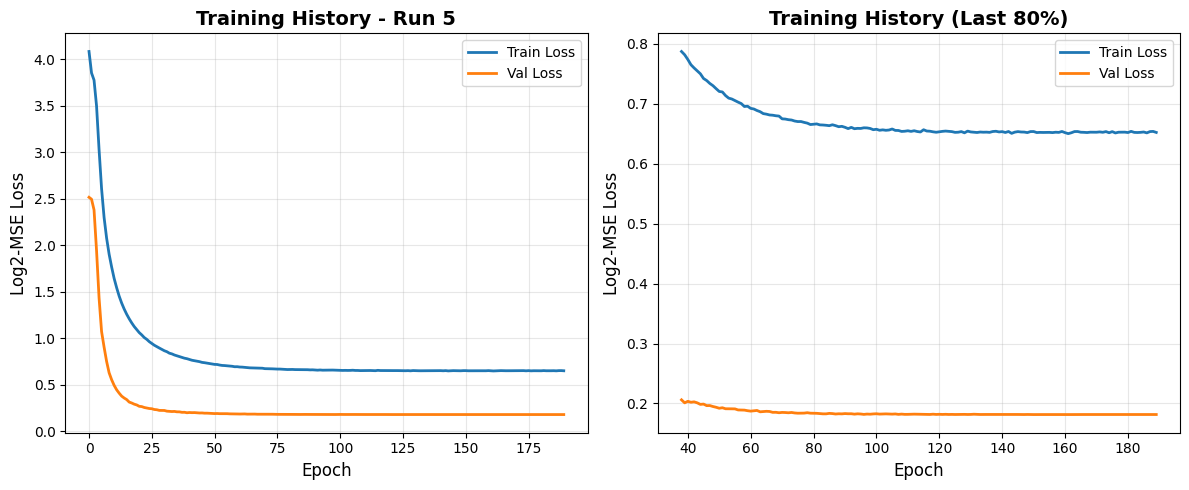

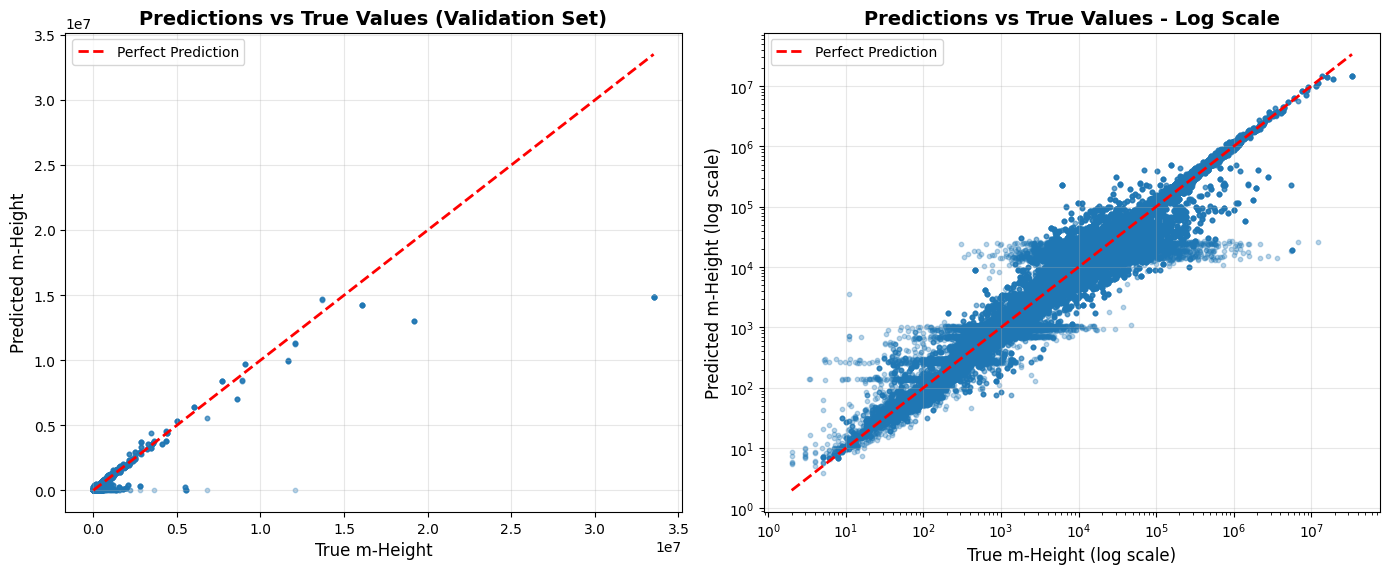

In [55]:
# Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Log2-MSE Loss', fontsize=12)
plt.title('Training History - Run 5', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
start_epoch = int(len(history.history['loss']) * 0.2)
plt.plot(range(start_epoch, len(history.history['loss'])),
         history.history['loss'][start_epoch:],
         label='Train Loss', linewidth=2)
plt.plot(range(start_epoch, len(history.history['val_loss'])),
         history.history['val_loss'][start_epoch:],
         label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Log2-MSE Loss', fontsize=12)
plt.title('Training History (Last 80%)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('run_5/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Predictions Scatter
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_val, alpha=0.3, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True m-Height', fontsize=12)
plt.ylabel('Predicted m-Height', fontsize=12)
plt.title('Predictions vs True Values (Validation Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_val, alpha=0.3, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True m-Height (log scale)', fontsize=12)
plt.ylabel('Predicted m-Height (log scale)', fontsize=12)
plt.title('Predictions vs True Values - Log Scale', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('run_5/predictions_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## Final Results Summary

In [56]:
print("="*70)
print("FINAL RESULTS SUMMARY - RUN 5")
print("="*70)
print(f"Training samples: {len(y_train):,}")
print(f"Validation samples: {len(y_val):,}")
print(f"Model parameters: {model.count_params():,}")
print()
print(f"Training log2-MSE:   {train_log2_mse:.6f}")
print(f"Validation log2-MSE: {val_log2_mse:.6f}")
print(f"Train-Val gap:       {abs(train_log2_mse - val_log2_mse):.6f}")
print(f"Target to beat:      0.374000")
print()

if val_log2_mse < 0.374:
    improvement = ((0.374 - val_log2_mse) / 0.374) * 100
    print(f"✅ SUCCESS! Beat target by {improvement:.1f}%")
    print(f"   Improvement: {0.374 - val_log2_mse:.6f}")
else:
    deficit = ((val_log2_mse - 0.374) / 0.374) * 100
    print(f"⚠️  Did not beat target (worse by {deficit:.1f}%)")
    print(f"   Need to improve by: {val_log2_mse - 0.374:.6f}")

print()
print("All predictions ≥ 1.0:", "✅ Yes" if y_pred_val.min() >= 1.0 else "❌ No")
print(f"Prediction range: [{y_pred_val.min():.2f}, {y_pred_val.max():.2f}]")

FINAL RESULTS SUMMARY - RUN 5
Training samples: 2,386,800
Validation samples: 421,200
Model parameters: 5,630,369

Training log2-MSE:   0.177264
Validation log2-MSE: 0.181483
Train-Val gap:       0.004218
Target to beat:      0.374000

✅ SUCCESS! Beat target by 51.5%
   Improvement: 0.192517

All predictions ≥ 1.0: ✅ Yes
Prediction range: [3.83, 14873045.00]
